In [79]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [80]:
cd workspace/theislab/mubind/notebooks

[Errno 2] No such file or directory: 'workspace/theislab/mubind/notebooks'
/mnt/c/Users/ignacio.ibarra/Dropbox/workspace/theislab/mubind/notebooks


In [81]:
import mubind as mb
import numpy as np
import pandas as pd
import torch
import bindome as bd
bd.constants.ANNOTATIONS_DIRECTORY = 'annotations'
# mb.models.MultiBind
import torch.optim as topti
import torch.utils.data as tdata
import matplotlib.pyplot as plt
import logomaker
import os
import scipy
import pickle

# Use a GPU if available, as it should be faster.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Using device: " + str(device))

Using device: cuda:0


In [106]:
adata = mb.bindome.datasets.scATAC.PBMCs_10x_v2(datadir='../../atac_poisson_study/data/')
peak_ids = adata.var_names

In [107]:
adata.shape

(10246, 165434)

In [108]:
extend = 50

In [109]:
adata.var['summit'] = ((adata.var['end'] + adata.var['start']) / 2).astype(int)
adata.var['summit.start'] = adata.var['summit'] - extend
adata.var['summit.end'] = adata.var['summit'] + extend

In [110]:
adata.var['k.summit'] = adata.var['chr'] + ':' + adata.var['summit.start'].astype(str) + '-' + adata.var['summit.end'].astype(str)

In [111]:
adata.shape

(10246, 165434)

In [112]:
n_seqs = 2000 # adata.shape[1] # None # 1000
seqs = mb.bindome.tl.get_sequences_from_bed(adata.var[['chr', 'summit.start', 'summit.end']].head(n_seqs), genome='hg38', uppercase=True)
keys = set([s[0] for s in seqs])
adata = adata[:,adata.var['k.summit'].isin(keys)]
# seqs = [[s[0], s[1].upper()] for s in seqs[0]]

/tmp/tmp83p4qj7m
genome hg38 False
options
/mnt/c/Users/ignacio.ibarra/Dropbox/annotations/hg38/genome/hg38.fa
True /mnt/c/Users/ignacio.ibarra/Dropbox/annotations/hg38/genome/hg38.fa
running bedtools...
bedtools getfasta -fi /mnt/c/Users/ignacio.ibarra/Dropbox/annotations/hg38/genome/hg38.fa -bed /tmp/tmp83p4qj7m -fo /tmp/tmpg4pdxis2


In [113]:
len(seqs)

2000

In [114]:
# remove Ns
for s in seqs:
    if 'N' in s:
        assert False
    # seqs = [[s[0], s[1].replace('N', '')] for s in seqs]
counts = adata.X.T

In [115]:
next_data = pd.DataFrame(counts.A) # sparse.from_spmatrix(counts.A)
# next_data = pd.DataFrame.sparse.from_spmatrix(counts)# var = []
# for ri, r in next_data.iterrows():
#     if ri % 1000 == 0:
#         print(ri, next_data.shape)
#     # print(ri, r.values[:-1], r.values[:-1].var())
#     var.append(r.values[:-1].var())
#     # break



In [116]:
next_data['var'] = next_data.var(axis=1)
# next_data = next_data[range(100)].copy()

In [117]:
next_data.index = [s[1] for s in seqs]
next_data.index.name = 'seq'

In [118]:
# sum_index = next_data[next_data.columns[:-1]].var(axis=1).sort_values(ascending=False).index

In [119]:
n_cells = 15000
top_var = next_data[['var']].sort_values('var', ascending=False).index[:n_cells]

In [120]:
# next_data = next_data.head(10000)
next_data_sel = next_data.reindex(top_var) # .reset_index(drop=True)

In [121]:
next_data_sel

,0,1,2,3,4,5,6,7,8,9,...,10237,10238,10239,10240,10241,10242,10243,10244,10245,var
seq,,,,,,,,,,,,,,,,,,,,,
CGCCCCAAGGATTCGCTCTTGCGTCACCGCCTCGCCTTCAGGACGCCTCCGCGCCTCGCCCTGTCCCCAGGGTCAATTCTGGGGTCACCGCCTGTCCCCA,3.0,1.0,6.0,5.0,4.0,1.0,9.0,1.0,3.0,5.0,...,4.0,1.0,3.0,0.0,6.0,1.0,2.0,2.0,1.0,3.954389
TTAACTCAGCCTGTGGGCGGGGCTGCGCGGTGCGGGGCGGGGCCTTGTGGCGCATGTGAACGCTCATTGGGCCCTCCTGGAAGGGGGCGAGACCAGCGAC,3.0,1.0,2.0,2.0,3.0,1.0,7.0,4.0,3.0,3.0,...,1.0,4.0,1.0,7.0,3.0,1.0,6.0,1.0,5.0,2.986213
GCCGCCATGTTTGAGCGAGGTGGGCAACTATGTTCTTGAGGGGGGAGCAACCATGTTCTTGAGGGGCTCTTCCCTTGAAGCCTCTTTGGCCACCATGTTT,0.0,1.0,1.0,2.0,1.0,1.0,3.0,3.0,0.0,0.0,...,5.0,4.0,3.0,0.0,0.0,1.0,6.0,0.0,5.0,2.815957
CTCGAGGAAATATTCCGTGTCGGGCCCGTCCTGATTGGACAGTTCTTTCGGGTTCTGGCCACTAGGAAGCTTTGTTTAGGTCCGGAAGGCGGGCTTTCCT,2.0,3.0,0.0,3.0,3.0,1.0,7.0,3.0,1.0,1.0,...,3.0,4.0,1.0,1.0,3.0,3.0,1.0,4.0,2.0,2.670848
CCTGTCTGGAGCCAGTGACCTCATTTCCTGTCTGTGTCACTCTGTCCTGACCTCATTTCCTGTCTGTGCCACTCTTTGTCCTGACCTCATTTCCTGTATG,5.0,0.0,1.0,0.0,1.0,2.0,1.0,1.0,1.0,3.0,...,4.0,2.0,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.922543
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GGCCTGGAAGGGCACCCACACCCCCAGGCGAGCATCGGACAGCCTGGAGCAGCACCCCACACCCCCAGGGGAGCATCCGACAGCCTGGAGCAGCACCCAC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003697
CACCAACACCCCGTCACTGCTCCAGAACCCCTGGCAGCCACAGAGCTCAGGCTTCAACGCTGGCCCGACACCAGGGCCAGGCCAGAAATCAGCCTGGGAG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003600
TGCAGATAAACAGACCCTGCCAGCCCTTGAGGAGGCTCATGGTAGAGTGGGAAGGACAATGTGTGTTCTGCTTCCACTGATGGGCTGGGGGCTTTGGTAT,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003212


In [122]:
del next_data_sel['var']
# next_data_sel.index = next_data_sel['seq']
# del next_data_sel['seq']

In [123]:
df = next_data_sel.copy() # sample
df = df[df.columns[:5000]] # .head(100) # sample

# shorten sequences/remove duplicates
df.index = df.index.astype(str).str[35:-35]
df = df[~df.index.duplicated(keep='first')]

df = df[df.sum(axis=1) != 0] # remove zeroes

df.shape

(2000, 5000)

In [124]:
# df2 = []
# for i in df.columns:
#     df3 = df[[i]].copy()
#     df3 = df3.head(100)
#     df3.columns = [0]
#     df3[1] = 1 # need a minimal non-zero count
#     df3['batch'] = i
#     df2.append(df3)
# df2 = pd.concat(df2)
# # df2['is_count_data'] = True
# dataset = mb.datasets.SelexDataset(df2, n_rounds=2, labels=[0, 1], enr_series=False)
dataset = mb.datasets.SelexDataset(df, n_rounds=df.shape[1], enr_series=False)


In [125]:
# df = next_data_sel.copy()
# dataset = mb.datasets.GenomicsDataset(df)
# train = tdata.DataLoader(dataset=dataset, batch_size=1000, shuffle=True)

train = tdata.DataLoader(dataset=dataset, batch_size=512, shuffle=True)

In [126]:
df.sum(axis=0)

0       248.0
1       121.0
2       313.0
3       300.0
4       164.0
        ...  
4995    221.0
4996    301.0
4997    113.0
4998     16.0
4999    177.0
Length: 5000, dtype: float64

In [127]:
log_etas = torch.tensor(np.log(df.sum(axis=0) / df.sum().sum())).reshape(1, df.shape[1]).to(device)
log_etas

/home/rio/miniconda3/envs/mubind/lib/python3.10/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


tensor([[ -8.4355,  -9.1531,  -8.2027,  ...,  -9.2215, -11.1763,  -8.7728]],
       device='cuda:0', dtype=torch.float64)

In [128]:
import torch.optim as topti


In [129]:
model, best_loss = mb.tl.optimize_iterative(train, device, num_epochs=500, show_logo=False, use_mono=True, use_dinuc=False, dinuc_mode='local',
                                            opt_kernel_shift=[0, 0, 1, 1],
                                            opt_kernel_length=[0, 0, 1, 1],
                                            shift_max=1, shift_step=1, optimiser=topti.Adam    ,
                                            n_batches=1, n_rounds=df.shape[1], num_epochs_shift_factor=1, log_etas=log_etas, # log_etas=log_etas,
                                            kernels = [0] + [2] + [20, 20],
                                            early_stopping=50, log_each=10, n_kernels=4, w=25, max_w=25) #  target_dim=train.dataset.signal.shape[1])

next w 25 <class 'int'>
# rounds 5000
# rounds 5000
# use_mono True
# use_dinuc False
# dinuc_mode local
# batches 1
# kernels 4
# initial w 25
# enr_series False

Kernel to optimize 0

FREEZING KERNELS
optimizing feature type mono
setting grad status of kernel (mono, dinuc) at 0 to (1, 0)
setting grad status of kernel (mono, dinuc) at 1 to (0, 0)
setting grad status of kernel (mono, dinuc) at 2 to (0, 0)
setting grad status of kernel (mono, dinuc) at 3 to (0, 0)


kernels mask None
optimizer:  Adam 
criterion: PoissonLoss 
# epochs: 500 
early_stopping: 50
lr= 0.01, weight_decay= 0, dir weight= 0
Epoch: 11, Loss: 0.234448,  best epoch: 9,  secs per epoch: 1.094 s,  secs epoch*1k trials: 0.547s
Epoch: 21, Loss: 0.233856,  best epoch: 19,  secs per epoch: 1.007 s,  secs epoch*1k trials: 0.504s
Epoch: 31, Loss: 0.233866,  best epoch: 19,  secs per epoch: 0.981 s,  secs epoch*1k trials: 0.491s
Epoch: 41, Loss: 0.233756,  best epoch: 35,  secs per epoch: 0.969 s,  secs epoch*1k trials: 0.4

In [130]:
r2 = mb.tl.scores(model, train, by='batch')
print("R^2:", r2)


/mnt/c/Users/ignacio.ibarra/Dropbox/workspace/theislab/mubind/mubind/tl/prediction.py:1111: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  counts['batch'] = train.dataset.batch
/mnt/c/Users/ignacio.ibarra/Dropbox/workspace/theislab/mubind/mubind/tl/prediction.py:1112: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  counts['n_rounds'] = train.dataset.n_rounds
/mnt/c/Users/ignacio.ibarra/Dropbox/workspace/theislab/mubind/mubind/tl/prediction.py:1136: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of c

R^2: {0: {'r2_counts': 0.3434316958819231, 'r2_foldchange': 0.032047355608736616, 'r2_enr': -0.028727488690784453, 'r2_fc': 0.03477033686528061, 'pearson_foldchange': 0.18646805856575172}}


True
4
(4, 4)
(96, 96)
(92, 92)


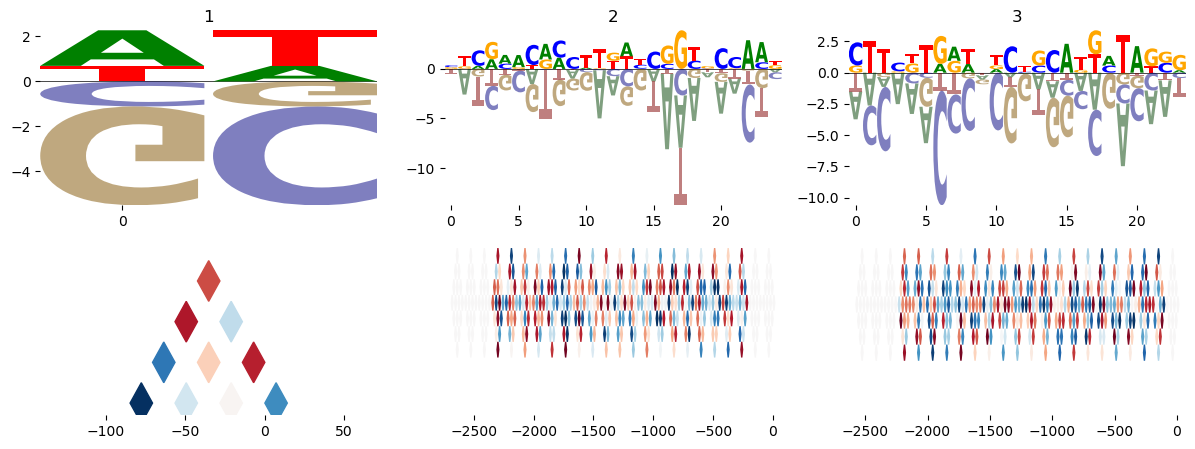

In [131]:
from matplotlib import rcParams
rcParams['figure.figsize'] = 20, 5
rcParams['figure.dpi'] = 100
mb.pl.conv(model, n_cols=2, show=True)
plt.show()
